In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
# Read in 
df9 = pd.read_csv('../data/df9.csv')

In [3]:
# Inspect
df9

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,-1.912877,-0.509738,1.935923,-2.119992,0.474137,3.647543,A2,B2,C33,D3,-23.858957
1,-0.341252,0.341502,2.268666,-0.948835,-0.492523,4.159113,A1,B4,C32,D2,4.795576
2,0.658157,-0.347933,3.104409,0.236928,0.359240,6.498557,A1,B4,C4,D2,16.359090
3,2.288540,-1.028834,3.554489,-0.215137,-0.436760,7.154874,A2,B1,C11,D3,-24.550723
4,0.618358,-1.526877,3.857197,-0.343902,0.098206,7.857794,A2,B2,C12,D3,-23.033020
...,...,...,...,...,...,...,...,...,...,...,...
995,-0.377935,-0.810448,3.658649,0.614948,-1.292935,7.227878,A1,B1,C13,D3,14.729703
996,0.968435,1.273159,3.449217,-0.073787,1.088958,6.701653,A1,B4,C42,D2,5.337900
997,0.919181,-1.518937,3.427333,1.152154,0.039267,6.797440,A2,B1,C22,D3,-8.781643
998,0.248702,-0.184816,2.923806,1.188720,-0.361918,6.040283,A2,B5,C11,D2,-15.494192


# Let's test a variety of holdouts on each of our four model types

***Ignoring x9 for the sake of simplicity***

- GLM
- Tree
- Random Forest
- GBM

General flow for each algorithm:

- Set sequence of random seeds
- For each seed:
    - Split into train/test (70/30 split)
    - Fit model on train
    - Evaluate on test
    - Save train errors and test errors (for comparing both within-seed and across seed variation)

### Build out for GLM first

In [4]:
def fit_glm(seed):
    # Set seed (you could also use random_state in train_test_split)
    np.random.seed(seed)
    
    # Split train/test
    df_train, df_test = train_test_split(df9, test_size=.3)
    
    # Fit model
    glm = smf.ols(
        formula='''y ~ x1 + np.power(x1, 2) + np.power(x1, 3) +
                       np.power(x2, 2)*x7 +
                       x4 +
                       x5 + np.power(x5, 2) + np.power(x5, 3) +
                       x8 + x10''',
        data=df_train
    ).fit()    
    
    # Return dictionary of train and test errors
    return {
        'train_err': df_train['y'] - glm.predict(df_train),
        'test_err': df_test['y'] - glm.predict(df_test)
    }

In [5]:
# Test for one seed
glm_0 = fit_glm(0)

# Inspect
glm_0

{'train_err': 105     4.606279
 68      9.186812
 479    -0.061038
 399    -1.155023
 434    -9.787948
          ...    
 835     4.867136
 192    -2.042414
 629     7.799803
 559    -4.663748
 684    13.816848
 Length: 700, dtype: float64,
 'test_err': 993    -7.538324
 859     7.336013
 298     1.962501
 553   -12.367856
 672    -3.354093
          ...    
 167    -1.325015
 998    -8.286180
 984    -8.638309
 491   -12.156354
 10     -0.305572
 Length: 300, dtype: float64}

In [6]:
# Compare average mean squared errors
def amse(err):
    return np.sum(err ** 2) / len(err)

print(f'''
Train error: {amse(glm_0['train_err'])}
Test error: {amse(glm_0['test_err'])}
''')


Train error: 60.668959060796496
Test error: 61.52048447221103



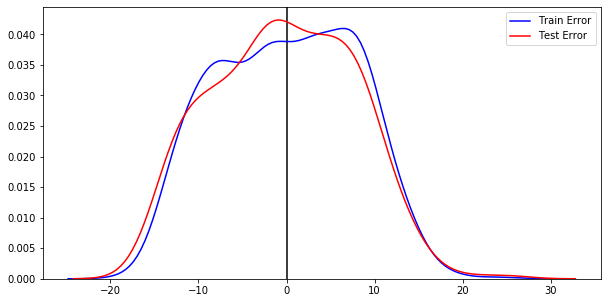

In [7]:
# Plot train and test error distributions
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
sb.distplot(glm_0['train_err'], hist=False, color='blue', label='Train Error')
sb.distplot(glm_0['test_err'], hist=False, color='red', label='Test Error')

Bit hard to tell in the graph, but average MSE is a little bit worse on the test data.  Ideally we want to see the train and test errors look more or less the same, but it's fairly common to have test metrics that looks a little bit worse that train metrics.  Comparing the relative difference can help, which here is about 2% (~1/60).

Now let's summarize 10 different train/test splits.

In [8]:
# Fit 10 different train/test splits
glm_err = []
for i in range(10):
    glm_err.append(fit_glm(i))

In [9]:
# Inspect one
glm_err[3]

{'train_err': 926    -0.479961
 411     7.413181
 224   -12.184692
 14     -1.248976
 170   -10.614919
          ...    
 952   -12.984785
 643    10.705868
 249    -2.019822
 664     1.933117
 874    12.383082
 Length: 700, dtype: float64,
 'test_err': 642    -4.146929
 762     7.436569
 909   -13.647234
 199     1.123322
 586    -6.762614
          ...    
 466   -12.462900
 654     3.997120
 279     2.702487
 945     6.245419
 186    -7.323468
 Length: 300, dtype: float64}

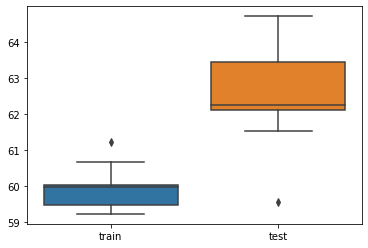

In [10]:
# Inspect train/test AMSEs
def plot_amse(err_list):
    train_amse = [amse(x['train_err']) for x in err_list]
    test_amse = [amse(x['test_err']) for x in err_list]
    sb.boxplot(
        x = np.repeat(['train', 'test'], 10),
        y = train_amse + test_amse
    )
    
plot_amse(glm_err)

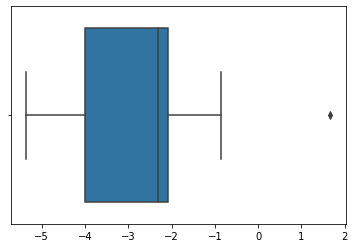

In [11]:
# Inspect the difference in train/test AMSE
def plot_diff_amse(err_list):
    diff_amse = [amse(x['train_err']) - amse(x['test_err']) for x in err_list]
    sb.boxplot(diff_amse)
    
plot_diff_amse(glm_err)

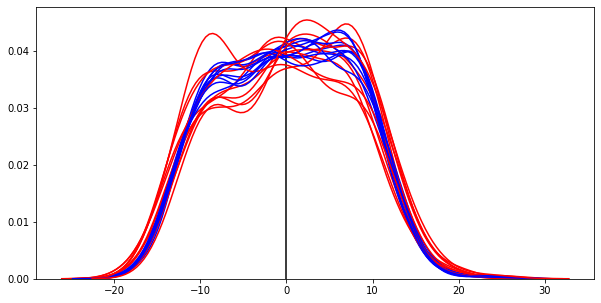

In [12]:
# Plot train and test error distributions
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
for i in glm_err:
    sb.distplot(i['train_err'], hist=False, color='blue')
    sb.distplot(i['test_err'], hist=False, color='red')

Things that stick out:

- Out of 10 iterations, the lowest test eror is still higher than the worst train error
- We consistently see test perform 2-4 AMSE worse than training (roughly 3-7% worse)
- Oddly, one iteration had test performance better than the train performance

Now replicate for the other model types

### Decision tree

In [13]:
def fit_tree(seed):
    # Set seed (you could also use random_state in train_test_split)
    np.random.seed(seed)
    
    # Create X/y
    predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10']
    X, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x8', 'x10']), df9['y']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
    
    # Fit model
    tree = DecisionTreeRegressor(
        max_depth=10,
        min_samples_leaf=25,
    ).fit(X_train, y_train)
    
    # Return dictionary of train and test errors
    return {
        'train_err': y_train - tree.predict(X_train),
        'test_err': y_test - tree.predict(X_test)
    }

In [14]:
# Fit 10 different train/test splits
tree_err = []
for i in range(10):
    tree_err.append(fit_tree(i))

In [15]:
# Inspect one
tree_err[3]

{'train_err': 926     0.024632
 411    15.161784
 224    -4.938915
 14      4.491905
 170    -6.882096
          ...    
 952   -12.745105
 643     9.262613
 249    -5.400989
 664     9.069951
 874     9.998611
 Name: y, Length: 700, dtype: float64,
 'test_err': 642    -9.886729
 762     4.148707
 909   -10.455647
 199    26.034523
 586    -7.815596
          ...    
 466   -19.681046
 654     1.755108
 279    -3.101111
 945    -0.147631
 186    -3.551473
 Name: y, Length: 300, dtype: float64}

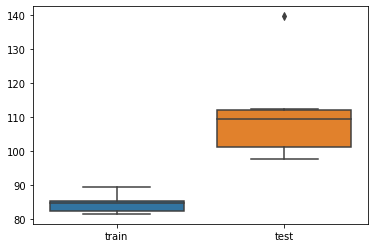

In [16]:
# Inspect train/test AMSEs
plot_amse(tree_err)

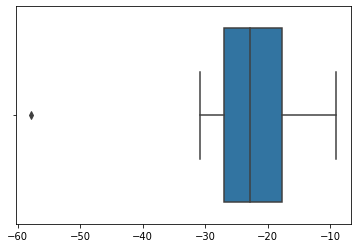

In [17]:
# Inspect the difference in train/test AMSE
plot_diff_amse(tree_err)

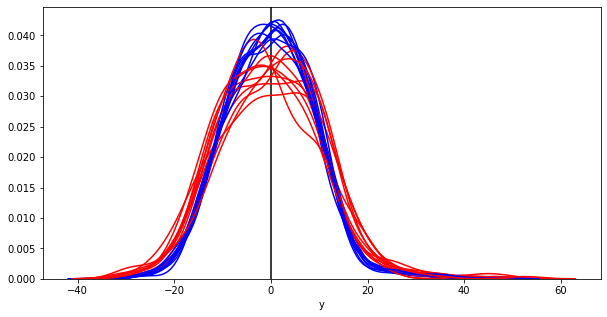

In [18]:
# Plot train and test error distributions
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
for i in tree_err:
    sb.distplot(i['train_err'], hist=False, color='blue')
    sb.distplot(i['test_err'], hist=False, color='red')

Vastly worse than the GLM!  Even the best performing iteration has a worse error than the worst performing GLM iteration.

### Random Forest

In [19]:
def fit_rf(seed):
    # Set seed (you could also use random_state in train_test_split)
    np.random.seed(seed)
    
    # Create X/y
    predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10']
    X, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x8', 'x10']), df9['y']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
    
    # Fit model
    tree = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=25,
        max_features='sqrt',
        n_jobs=-1
    ).fit(X_train, y_train)
    
    # Return dictionary of train and test errors
    return {
        'train_err': y_train - tree.predict(X_train),
        'test_err': y_test - tree.predict(X_test)
    }

In [20]:
# Fit 10 different train/test splits
rf_err = []
for i in range(10):
    rf_err.append(fit_rf(i))

In [21]:
# Inspect one
rf_err[3]

{'train_err': 926     3.212988
 411     8.943500
 224   -10.247187
 14      7.609291
 170    -9.943426
          ...    
 952    -6.102811
 643    14.674094
 249    -8.115800
 664     3.307289
 874    10.902323
 Name: y, Length: 700, dtype: float64,
 'test_err': 642    -6.483440
 762     1.112102
 909   -12.279110
 199    31.172801
 586    -4.755280
          ...    
 466   -14.663799
 654     9.953853
 279     3.085640
 945     2.991935
 186    -7.535407
 Name: y, Length: 300, dtype: float64}

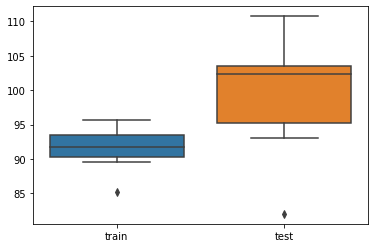

In [22]:
# Inspect train/test AMSEs
plot_amse(rf_err)

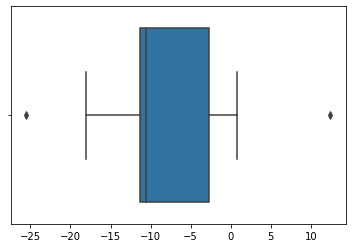

In [23]:
# Inspect the difference in train/test AMSE
plot_diff_amse(rf_err)

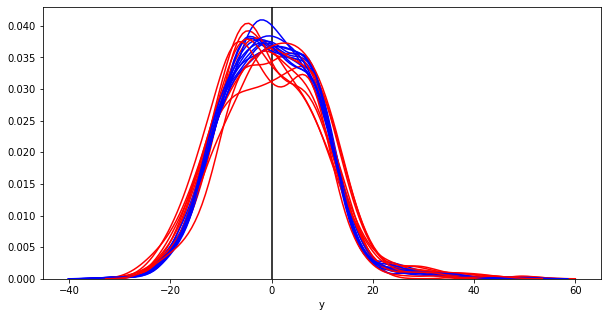

In [24]:
# Plot train and test error distributions
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
for i in rf_err:
    sb.distplot(i['train_err'], hist=False, color='blue')
    sb.distplot(i['test_err'], hist=False, color='red')

Interesting!  Train performance looks worse on RF than on the decision (medians of ~85 and ~92, respectively), but test performance is better (medians of ~110 and ~103, respectively).  But both worse than GLM.

### GBM

In [25]:
def fit_gbm(seed):
    # Set seed (you could also use random_state in train_test_split)
    np.random.seed(seed)
    
    # Create X/y
    predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10']
    X, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x8', 'x10']), df9['y']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
    
    # Fit model
    tree = GradientBoostingRegressor(
        loss='ls',
        learning_rate=0.1,
        n_estimators=100,
        max_depth=3,
        max_features='sqrt',
        n_iter_no_change=1  # Used for early stopping.  The moment that the performance looks worse on randomly held out data, we stop building more trees.
    ).fit(X_train, y_train)
    
    # Return dictionary of train and test errors
    return {
        'train_err': y_train - tree.predict(X_train),
        'test_err': y_test - tree.predict(X_test)
    }

In [26]:
# Fit 10 different train/test splits
gbm_err = []
for i in range(10):
    gbm_err.append(fit_gbm(i))

In [27]:
# Inspect one
gbm_err[3]

{'train_err': 926     2.276893
 411     8.926064
 224   -10.409496
 14      0.368059
 170    -9.916554
          ...    
 952    -6.444186
 643    14.667977
 249    -7.845592
 664     2.886123
 874    10.652250
 Name: y, Length: 700, dtype: float64,
 'test_err': 642    -5.463866
 762     2.608858
 909   -10.851465
 199    26.277105
 586    -3.251890
          ...    
 466   -13.121135
 654     8.736846
 279     4.607689
 945     3.271966
 186    -6.284081
 Name: y, Length: 300, dtype: float64}

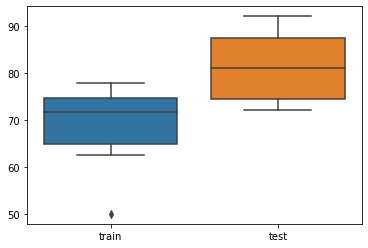

In [28]:
# Inspect train/test AMSEs
plot_amse(gbm_err)

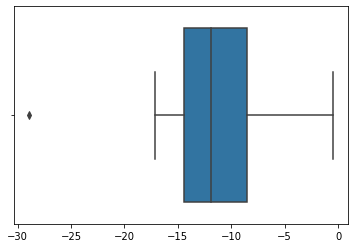

In [29]:
# Inspect the difference in train/test AMSE
plot_diff_amse(gbm_err)

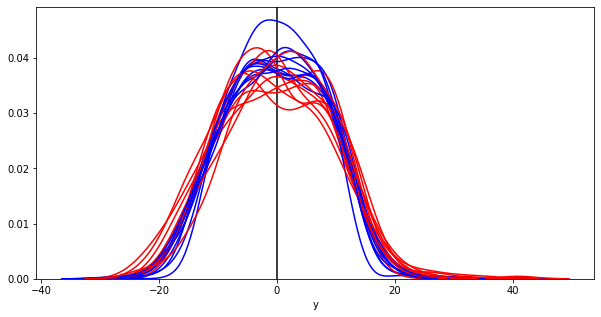

In [30]:
# Plot train and test error distributions
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
for i in gbm_err:
    sb.distplot(i['train_err'], hist=False, color='blue')
    sb.distplot(i['test_err'], hist=False, color='red')

Better than the tree and RF, not quite as good as the GLM.

Let's plot boxplots of test performance on one graph.

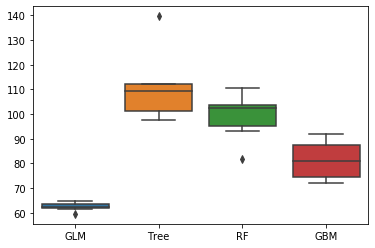

In [31]:
# Hacky
sb.boxplot(
    x = np.repeat(['GLM', 'Tree', 'RF', 'GBM'], 10),
    y = [amse(x['test_err']) for x in glm_err] +
        [amse(x['test_err']) for x in tree_err] +
        [amse(x['test_err']) for x in rf_err] +
        [amse(x['test_err']) for x in gbm_err]
)

Main takeaways:

- GLM win this data set (which makes sense because a lot of the overall signal is additive signals from individual variables)
- Tree does the worst, probably due to it's simplistic way of describing the world compared to the other models
- RF and GBM are both better than average than Tree, which is expected because with RF/GBM we're trying to improve the generalizability of basic decision trees

Remember this: Every data set is different.  Sometimes GLMs will outperform the rest, sometimes RF and GBM will reign supreme, and sometimes there isn't a clear winner. :)

# Cross-validation

Cross-validation extends the ideas we've talking about and instead separates the data into `k` distinct groups (called k-fold cross-validation.  By splitting the data into `k` distinct data sets, we're trying to maximize the general usefulness of our data to create a generalizable model by evaluating the model on many different test data sets.  It can be very useful for optimizing hyperparameters but can be computational demanding by requiring many different models to be fit if we set `k` to be high.

The basic idea:

- Split data into `k` distinct groups
- For each parameter value:
    - For each group:
        - Build a model on all groups but that group
        - Summarize model performance
    - Aggregate performance across all folks (e.g. by taking the mean)
- Pick the parameter value with the best aggregate performance
- Refit a model on the **whole** data set using that parameter!

Let's illustrate this using a basic decision to understand test what value of `min_samples_leaf` results in the best model (previously we just arbitrarily used values like 25 and 50 to represent some sort of "reasonable" percentage of the data).  Since this model fits really fast, let's do the following:

- `min_samples_leaf` values ranging from 1 to 200 by 5
- 4-fold cross-validation

In [32]:
# Get parameter values
param_values = [x for x in range(1, 200)]

# Inspect
param_values[:5], param_values[-5:]

([1, 2, 3, 4, 5], [195, 196, 197, 198, 199])

In [33]:
# Get matrices
predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10']
X, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x8', 'x10']), df9['y']

# Inspect
print(X[:5])
print()
print(y[:5])

         x1        x2        x3        x4        x5        x6  x7_A1  x7_A2  \
0 -1.912877 -0.509738  1.935923 -2.119992  0.474137  3.647543      0      1   
1 -0.341252  0.341502  2.268666 -0.948835 -0.492523  4.159113      1      0   
2  0.658157 -0.347933  3.104409  0.236928  0.359240  6.498557      1      0   
3  2.288540 -1.028834  3.554489 -0.215137 -0.436760  7.154874      0      1   
4  0.618358 -1.526877  3.857197 -0.343902  0.098206  7.857794      0      1   

   x8_B1  x8_B2  x8_B3  x8_B4  x8_B5  x10_D1  x10_D2  x10_D3  
0      0      1      0      0      0       0       0       1  
1      0      0      0      1      0       0       1       0  
2      0      0      0      1      0       0       1       0  
3      1      0      0      0      0       0       0       1  
4      0      1      0      0      0       0       0       1  

0   -23.858957
1     4.795576
2    16.359090
3   -24.550723
4   -23.033020
Name: y, dtype: float64


In [34]:
# For each parameter value, evaluate 4-fold cross-validation
scores = []
for p in param_values:
    # Initialize tree
    tree = DecisionTreeRegressor(
        min_samples_leaf=p,
    )
    
    # Get scores
    cv_score = cross_val_score(tree, X, y, cv=4, scoring='neg_mean_squared_error')  # By default uses the 
    
    # Save the mean score
    scores += [cv_score.mean()]

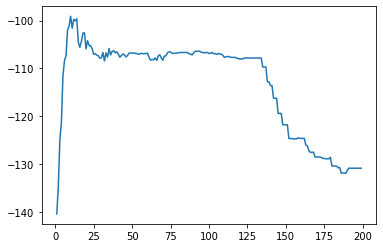

In [35]:
# Plot
sb.lineplot(x=param_values, y=scores)

In [36]:
# Get the number of minimum samples with the best performance (here, the highest value)
best_index = scores.index(max(scores))
best_score = scores[best_index]
best_param = param_values[best_index]

# Inspect
best_param, best_score

(10, -99.08170246677605)

10 samples, quite a bit lower that our previously used values.

Lastly, we refit the whole model using this parameter.

In [37]:
best_tree = DecisionTreeRegressor(
    min_samples_leaf=best_param,
).fit(X, y)

In [38]:
# In case you want to see all scoring function supported by scikit
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

Basically all practical and useful models, however, have much more than one hyperparameter (even basic decision trees do) so in reality we will test multiple sets of parameters.  There are generally two common ways to create you

- Grid search
    - Creates a fixed mesh across your hyperparameter space (e.g. what we did above by creating a grid from 1 to 100 incrementing by 1)
    - Works well when you a lot computation power to handle a lot of iterations and/or have some sort of prior knowledge for what sets of parameter ranges make the most sense
- Random search
    - Creates a random mesh across your hyperparameter space (e.g. if we have randomly sampled 10 values from 1 to 100)
    - Can work well if you have limited computational power and/or no sort of prior knowledge for what sets of parameter ranges make the most sense (e.g. could be used to find initial sets that seem good and then grid searching around those sets to fine tune them a little)